In [2]:
import sys 
sys.path.append("..")
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_len, output_len = 20, 10

In [3]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=True)
# features = getFeatures()

In [4]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 13])
torch.Size([64, 10])


In [9]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, covariate_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size+covariate_size, input_size)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell, covariates):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for t in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            covariate = covariates[:, t, :].unsqueeze(1)
            output = torch.cat((covariate, output), dim=2)
            output = self.fc(output) 
            outputs.append(output[:, :, -1].unsqueeze(2))
            x = output

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, covariate_size, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, covariate_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, historic_inputs, covariates):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(historic_inputs)
        xt = historic_inputs[:, -1, :].unsqueeze(1) 
        outputs = self.decoder(xt, h, c, covariates) # (batch_size, output_len, 1)
        return outputs

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

hist_input_size = len(select_features)
covariate_size = 6
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(hist_input_size, input_len, covariate_size, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

cuda


In [11]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 25
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        hist_inputs = inputs[:, :, :hist_input_size].to(device)
        covariates = inputs[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(hist_inputs, covariates)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        hist_inputs = inputs[:, :, :hist_input_size].to(device)
        covariates = inputs[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)

        with torch.no_grad():
            outputs = seq2seq(hist_inputs, covariates) 
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select2_covariate_best_model_{input_len}-{output_len}.pt')


Epoch 1/25 [TRAIN]:   0%|          | 0/2258 [00:00<?, ?it/s]

Epoch 1/25 [TRAIN]: 100%|██████████| 2258/2258 [01:11<00:00, 31.58it/s, train_loss=0.00347]


Epoch 1/25, Average Training Loss: 0.006457


Epoch 1/25 [VAL]: 100%|██████████| 756/756 [00:09<00:00, 75.70it/s, val_loss=0.00455]


Epoch 1/25, Average Validation Loss: 0.003962


Epoch 2/25 [TRAIN]: 100%|██████████| 2258/2258 [15:51<00:00,  2.37it/s, train_loss=0.00221]   


Epoch 2/25, Average Training Loss: 0.003856


Epoch 2/25 [VAL]: 100%|██████████| 756/756 [00:05<00:00, 149.20it/s, val_loss=0.00429]


Epoch 2/25, Average Validation Loss: 0.003770


Epoch 3/25 [TRAIN]: 100%|██████████| 2258/2258 [00:30<00:00, 75.14it/s, train_loss=0.00329]


Epoch 3/25, Average Training Loss: 0.003591


Epoch 3/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.49it/s, val_loss=0.00434]


Epoch 3/25, Average Validation Loss: 0.003408


Epoch 4/25 [TRAIN]: 100%|██████████| 2258/2258 [00:29<00:00, 77.29it/s, train_loss=0.00307]


Epoch 4/25, Average Training Loss: 0.003446


Epoch 4/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 185.89it/s, val_loss=0.00363]


Epoch 4/25, Average Validation Loss: 0.003263


Epoch 5/25 [TRAIN]: 100%|██████████| 2258/2258 [00:29<00:00, 76.67it/s, train_loss=0.00594]


Epoch 5/25, Average Training Loss: 0.003328


Epoch 5/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 183.31it/s, val_loss=0.00422]


Epoch 5/25, Average Validation Loss: 0.003079


Epoch 6/25 [TRAIN]: 100%|██████████| 2258/2258 [00:29<00:00, 76.03it/s, train_loss=0.00267]


Epoch 6/25, Average Training Loss: 0.003237


Epoch 6/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 182.87it/s, val_loss=0.00458]


Epoch 6/25, Average Validation Loss: 0.003516


Epoch 7/25 [TRAIN]: 100%|██████████| 2258/2258 [00:29<00:00, 76.08it/s, train_loss=0.00403]


Epoch 7/25, Average Training Loss: 0.003131


Epoch 7/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 183.05it/s, val_loss=0.00411]


Epoch 7/25, Average Validation Loss: 0.003093


Epoch 8/25 [TRAIN]: 100%|██████████| 2258/2258 [00:30<00:00, 74.71it/s, train_loss=0.00304]


Epoch 8/25, Average Training Loss: 0.003040


Epoch 8/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 172.74it/s, val_loss=0.00435]


Epoch 8/25, Average Validation Loss: 0.002901


Epoch 9/25 [TRAIN]: 100%|██████████| 2258/2258 [00:31<00:00, 71.76it/s, train_loss=0.00223]


Epoch 9/25, Average Training Loss: 0.002988


Epoch 9/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 168.27it/s, val_loss=0.00395]


Epoch 9/25, Average Validation Loss: 0.002814


Epoch 10/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 65.25it/s, train_loss=0.00411]


Epoch 10/25, Average Training Loss: 0.002914


Epoch 10/25 [VAL]: 100%|██████████| 756/756 [00:05<00:00, 129.01it/s, val_loss=0.0036] 


Epoch 10/25, Average Validation Loss: 0.002822


Epoch 11/25 [TRAIN]: 100%|██████████| 2258/2258 [00:35<00:00, 63.68it/s, train_loss=0.00227]


Epoch 11/25, Average Training Loss: 0.002871


Epoch 11/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 152.00it/s, val_loss=0.00327]


Epoch 11/25, Average Validation Loss: 0.002775


Epoch 12/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 67.26it/s, train_loss=0.0027] 


Epoch 12/25, Average Training Loss: 0.002840


Epoch 12/25 [VAL]: 100%|██████████| 756/756 [00:05<00:00, 150.42it/s, val_loss=0.00319]


Epoch 12/25, Average Validation Loss: 0.002765


Epoch 13/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 66.15it/s, train_loss=0.00387]


Epoch 13/25, Average Training Loss: 0.002811


Epoch 13/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 155.55it/s, val_loss=0.00317]


Epoch 13/25, Average Validation Loss: 0.002747


Epoch 14/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 65.82it/s, train_loss=0.00219]


Epoch 14/25, Average Training Loss: 0.002764


Epoch 14/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 155.36it/s, val_loss=0.00299]


Epoch 14/25, Average Validation Loss: 0.002770


Epoch 15/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 67.44it/s, train_loss=0.0022] 


Epoch 15/25, Average Training Loss: 0.002739


Epoch 15/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 157.90it/s, val_loss=0.00298]


Epoch 15/25, Average Validation Loss: 0.002689


Epoch 16/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 67.39it/s, train_loss=0.00225]


Epoch 16/25, Average Training Loss: 0.002735


Epoch 16/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 158.51it/s, val_loss=0.0036] 


Epoch 16/25, Average Validation Loss: 0.002849


Epoch 17/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 66.64it/s, train_loss=0.00247]


Epoch 17/25, Average Training Loss: 0.002709


Epoch 17/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 157.78it/s, val_loss=0.00354]


Epoch 17/25, Average Validation Loss: 0.002821


Epoch 18/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 66.97it/s, train_loss=0.00164]


Epoch 18/25, Average Training Loss: 0.002690


Epoch 18/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 156.48it/s, val_loss=0.00312]


Epoch 18/25, Average Validation Loss: 0.002663


Epoch 19/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 66.10it/s, train_loss=0.0013] 


Epoch 19/25, Average Training Loss: 0.002681


Epoch 19/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 157.40it/s, val_loss=0.0031] 


Epoch 19/25, Average Validation Loss: 0.002681


Epoch 20/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 66.72it/s, train_loss=0.00268]


Epoch 20/25, Average Training Loss: 0.002654


Epoch 20/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 152.72it/s, val_loss=0.00355]


Epoch 20/25, Average Validation Loss: 0.002829


Epoch 21/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 66.66it/s, train_loss=0.0026] 


Epoch 21/25, Average Training Loss: 0.002655


Epoch 21/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 154.47it/s, val_loss=0.00316]


Epoch 21/25, Average Validation Loss: 0.002656


Epoch 22/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 65.90it/s, train_loss=0.0033] 


Epoch 22/25, Average Training Loss: 0.002628


Epoch 22/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 154.16it/s, val_loss=0.0034] 


Epoch 22/25, Average Validation Loss: 0.002659


Epoch 23/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 66.19it/s, train_loss=0.00147]


Epoch 23/25, Average Training Loss: 0.002630


Epoch 23/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 154.88it/s, val_loss=0.00321]


Epoch 23/25, Average Validation Loss: 0.002755


Epoch 24/25 [TRAIN]: 100%|██████████| 2258/2258 [00:33<00:00, 66.47it/s, train_loss=0.00186]


Epoch 24/25, Average Training Loss: 0.002601


Epoch 24/25 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 155.57it/s, val_loss=0.00276]


Epoch 24/25, Average Validation Loss: 0.002673


Epoch 25/25 [TRAIN]: 100%|██████████| 2258/2258 [00:34<00:00, 65.46it/s, train_loss=0.00407]


Epoch 25/25, Average Training Loss: 0.002598


Epoch 25/25 [VAL]: 100%|██████████| 756/756 [00:05<00:00, 138.36it/s, val_loss=0.00353]

Epoch 25/25, Average Validation Loss: 0.002683


In [12]:
features = getFeatures()

Test loss: 0.0018312925240024924
MAPE: 14.070018768310547


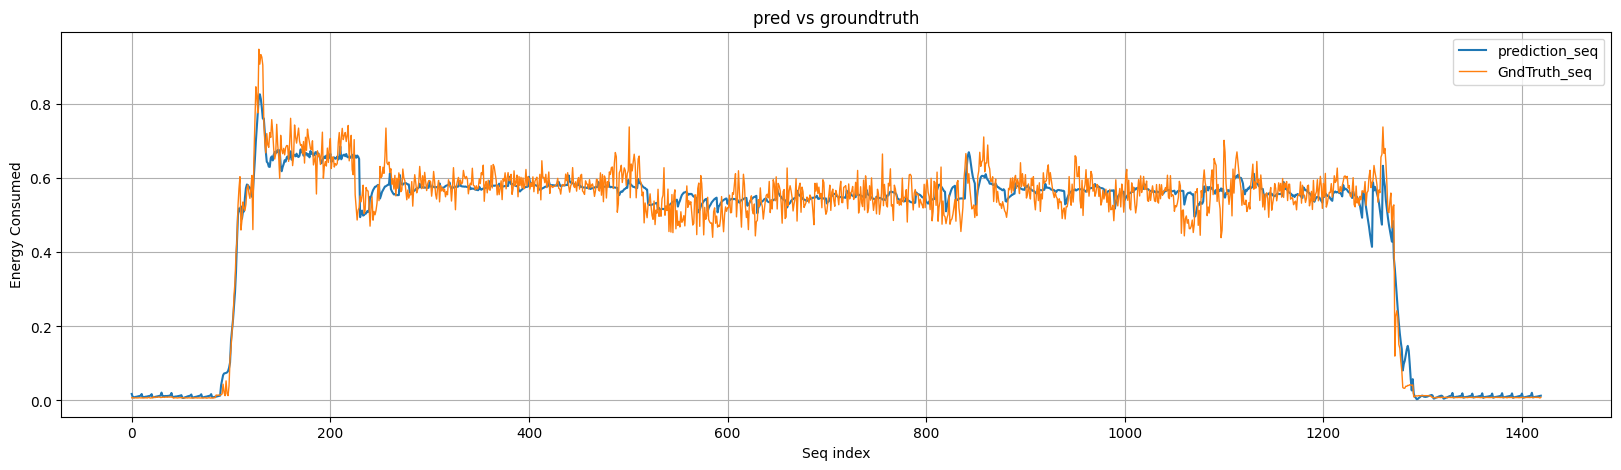

In [16]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_covariate_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 270 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features + features[-6:]].values, 
                                         test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    hist_inputs = input_seq[:, :, :hist_input_size].to(device)
    covariates = input_seq[:, :output_len, hist_input_size:].to(device)
    targets = targets.to(device)
    outputs = seq2seq(hist_inputs, covariates)

    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")

    # print(outputs.shape)
    # print(targets.shape)
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [26]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_covariate_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
mapes = []

for f_num in d_split['test']:
    test_data = data[(data['flight'] == f_num) &  (data['power'] > 0.05)]
    input_seq, output_seq = create_sequences(test_data[select_features+features[-covariate_size:]].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    # print(f"Flight {f_num}:")

    with torch.no_grad():
        
        hist_inputs = input_seq[:, :, :hist_input_size].to(device)
        covariates = input_seq[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        outputs = seq2seq(hist_inputs, covariates)

        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        # error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        # print(f"MAPE: {mape}")

        mapes.append(mape)

print(f"Average MAPE: {torch.mean(torch.tensor(mapes))}")

Average MAPE: 8.384781837463379


In [27]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


TypeError: forward() missing 1 required positional argument: 'covariates'

It seems LSTM-LSTM is better than current design of TCN-LSTM